In [1]:
import sys
sys.path.append("..")
sys.path.append("../ADsurf")
sys.path.append("../ADsurf/_cps")
from ADsurf._ADsurf import *

data_path = "./data/01_sandwich_layer/"
model = Model()

## 1. Model parameter

In [2]:
dc = 0.001
vmin = 0.2
vmax = 0.4
tmin = 1/100
tmax = 1/5
layering_method     = "LN"
initialize_method   = "Constant"
layering_ratio      = 2.5
depth_factor        = 2.5
layer_number        = 3
vp_vs_ratio         = 2.45
rho                 = 2
fundamental_range   = [1/37,1/8]
model_parameter = Model_param(
            dc=dc,
            vmin=vmin,
            vmax=vmax,
            tmin=tmin,
            tmax=tmax,
            layering_method=layering_method,
            initialize_method=initialize_method,
            layering_ratio=layering_ratio,
            depth_factor=depth_factor,
            layer_number=layer_number,
            vp_vs_ratio=vp_vs_ratio,
            rho=rho,
            fundamental_range = fundamental_range
            )

## 2. inversion parameter

In [3]:
inversion_method = "vs-and-thick"
wave = "rayleigh"
algorithm = "dunkin"
itype = 0
mode  = 0
compress = True
compress_method="exp"
normalized = True
lr              = 0.001
damp_vertical   = 0.
damp_horizontal = 0.
iteration = 1000
step_size = 200
gamma = 0.75
optimizer="Adam"

inversion_parameter = inv_param(
                inversion_method=inversion_method,
                wave=wave,
                algorithm=algorithm,
                mode=mode,
                compress=compress,
                compress_method=compress_method,
                normalized=normalized,
                lr=lr,
                damp_vertical=damp_vertical,
                damp_horizontal=damp_horizontal,
                iteration=iteration,
                step_size=step_size,
                gamma=gamma,
                optimizer=optimizer
)

## 3.Model parameterization and initializing

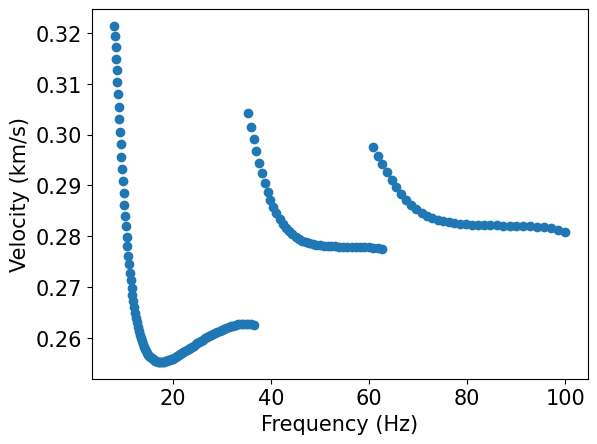

In [4]:
pvs_obs = np.loadtxt(os.path.join(data_path,"input/disper.txt"))
plt.figure()
plt.scatter(1/pvs_obs[:,0],pvs_obs[:,1])
plt.tick_params(labelsize=15)
plt.xlabel("Frequency (Hz)",fontsize=15)
plt.ylabel("Velocity (km/s)",fontsize=15)
plt.show()

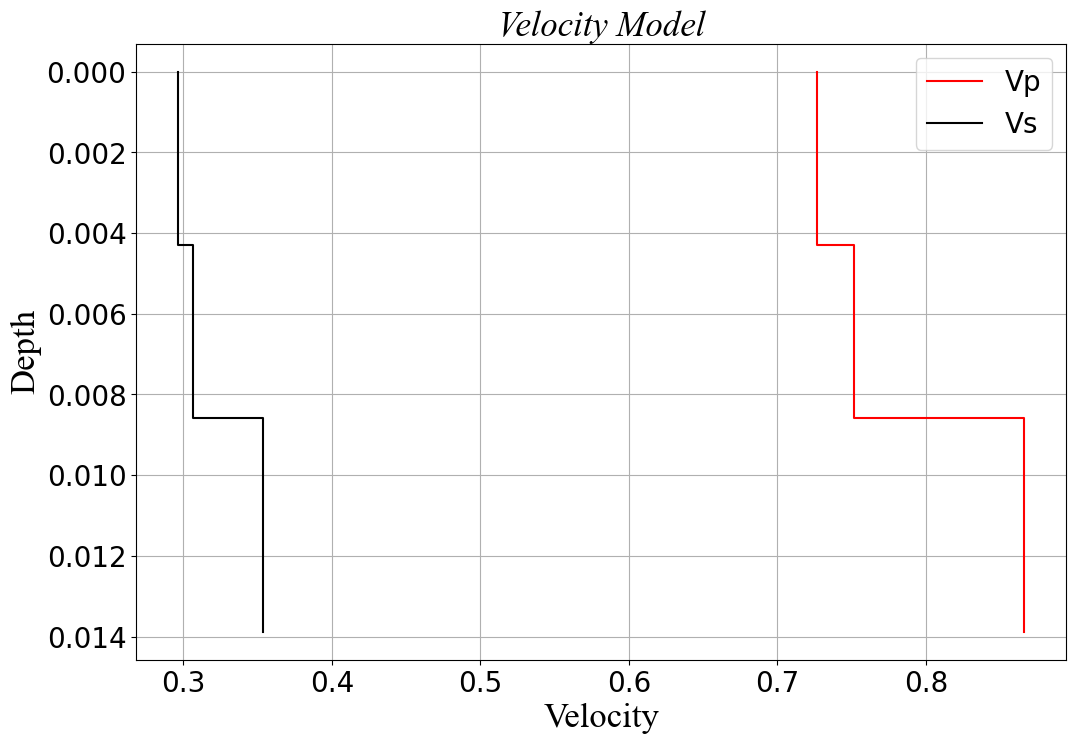

{'vs': array([0.29658779, 0.3067277 , 0.35351081]),
 'vp': array([0.72664008, 0.75148288, 0.86610148]),
 'rho': array([2., 2., 2.]),
 'thick': array([0.0042938, 0.0042938, 0.0052938]),
 'layer_mindepth': array([0.00240039, 0.00240039, 0.00240039]),
 'layer_maxdepth': array([0.01588141, 0.01588141, 0.01588141])}

In [5]:
thick = np.array([0.005,0.005,0.005])
initial_model = Init_model(
                        model_param = model_parameter,
                        pvs_obs=pvs_obs,
                        thick=thick # if the layering method =="",you may need to specified the thickness manually
                        )
initial_model.init_model["thick"][0] = initial_model.init_model["thick"][0]-0.001 
initial_model.init_model["thick"][1] = initial_model.init_model["thick"][1]-0.001 

plot_velModel(thick =initial_model.init_model["thick"],
              vp    = initial_model.init_model["vp"],
              vs    = initial_model.init_model["vs"],
            )
initial_model.init_model

### MonteCarlo Search for initial model
default not run (you can uncommont it)

In [6]:
# np.random.seed(123)
MonteCarlo_model = init_model_MonteCarlo(
                                        model_parameter,
                                        initial_model,
                                        sampling_num=100,
                                        sampling_method="normal",
                                        vsrange_sign="plus",
                                        vsrange=[-0.1,0.2],
                                        sigma_vs= 20,
                                        sigma_thick= 20,
                                        )

MonteCarlo: Iter:99,loss:0.14072: 100%|██████████| 100/100 [00:04<00:00, 23.29it/s]


### plot all the initial model

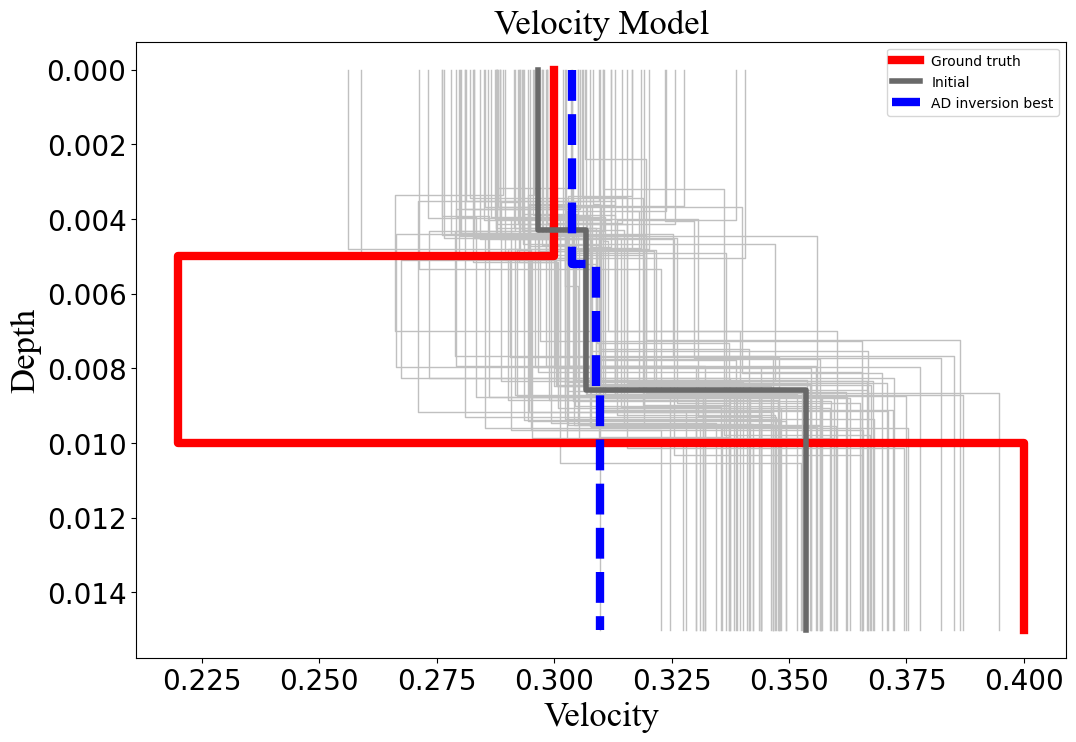

In [7]:
# figure to show the searching result
MonteCarlo_vs = MonteCarlo_model.MonteCarlo_model["vs"]
MonteCarlo_thick = MonteCarlo_model.MonteCarlo_model["thick"]
MonteCarlo_vp = MonteCarlo_model.MonteCarlo_model["vp"]
MonteCarlo_rho = MonteCarlo_model.MonteCarlo_model["rho"]
MonteCarlo_initVs = MonteCarlo_model.MonteCarlo_model["vs"][0]
MonteCarlo_initthick = MonteCarlo_model.MonteCarlo_model["thick"][0]
loss_lists = MonteCarlo_model.MonteCarlo_model["loss"]
best_MonteCarlo = np.argmin(np.array(loss_lists))
# best_MonteCarlo = 170
thick_true  = np.array([0.005,0.005,0.005])
vs_true     = np.array([0.3,0.22,0.4])
plot_allModel(vs_inversion=MonteCarlo_vs,thick_inversion=MonteCarlo_thick,
            vs_true=vs_true,thick_true=thick_true,
            vs_init=MonteCarlo_initVs,thick_init=MonteCarlo_initthick,
            vs_matlab=[],thick_matlab=[],
            best_index=best_MonteCarlo,
            plot_all=True,
            largest_depth=0.015
            # save_path=os.path.join(config.save_path,"007_inversion_result.png")
            )

# redefine the initial model paramters
initial_model.init_model["vs"] = MonteCarlo_vs
initial_model.init_model["vp"] = MonteCarlo_vp
initial_model.init_model["thick"] = MonteCarlo_thick
initial_model.init_model["rho"] = MonteCarlo_rho

## 4. inversion

In [8]:
inversion_model = inversion(
                        model_param = model_parameter,
                        inv_param   = inversion_parameter,
                        init_model  = initial_model,
                        pvs_obs     = np.ones((MonteCarlo_vs.shape[0],pvs_obs.shape[0],2))*pvs_obs[:,:2],
                        vsrange_sign="plus",
                        vsrange     = [-0.8,0.8],
                        AK135_data=[],
                        device="cuda"
                        )

 32%|███▏      | 321/1000 [02:24<05:07,  2.21it/s]

## 5. plotting

In [ ]:
if not os.path.exists(os.path.join(data_path,"output/figure")):
    os.makedirs(os.path.join(data_path,"output/figure"))
if not os.path.exists(os.path.join(data_path,"output/data")):
    os.mkdir(os.path.join(data_path,"output/data"))

### Misfit
for a same learning rate, not all the initial model can be converged with the same iterations， but we can select some of the coverged model to do more research

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(12,8))
plt.plot(inversion_model.inv_process["loss"])
plt.xlabel("iteration",fontsize=15)
plt.ylabel("Misfit",fontsize=15)
plt.tick_params(labelsize="large")
plt.ylim(0,1)
plt.savefig(os.path.join(data_path,"output/figure/loss_curve.png"))
plt.show()

### Minimum misift

In [ ]:
best_index = np.argmin(inversion_model.inv_process["loss"],axis=0)
loss_lists = list2numpy(inversion_model.inv_process["loss"])
best_loss = np.zeros(best_index.shape[0])
for i in range(len(best_index)):
    best_loss[i] = loss_lists[best_index[i],i]
best_num = np.argmin(best_loss)
best_loss[best_num]

In [ ]:
iter_vs     = list2numpy(inversion_model.inv_process["iter_vs"])
vs_init     = list2numpy(initial_model.init_model["vs"])
thick_init  = list2numpy(initial_model.init_model["thick"])

if inversion_method == "vs-and-thick":
    iter_thick = list2numpy(inversion_model.inv_process["iter_thick"])
else:
    iter_thick = np.ones_like(iter_vs)*thick_init
vs_matlab = []
thick_matlab = []
best_iter = np.argmin(list2numpy(inversion_model.inv_process["loss"]),axis=0)
thick_true = np.array([0.005,0.005,0.005])
vs_true = np.array([0.3,0.22,0.4])

i = best_num
plot_allModel(vs_inversion=iter_vs[:,i,:],thick_inversion=iter_thick[:,i,:],
            vs_true=vs_true,thick_true=thick_true,
            vs_init=vs_init[i],thick_init=thick_init[i],
            vs_matlab=vs_matlab,thick_matlab=thick_matlab,
            best_index=best_iter[i],
            plot_all=True,
            save_path=os.path.join(data_path,"output/figure/Inverted_result.png".format(i)),
            largest_depth=0.025,
            show=True
            )

In [ ]:
import os 
import json 

def numpy2list(a):
    """
        transform numpy data into tensor
    """
    if not isinstance(a,list):
        return a.tolist()
    else:
        return a

config_res = {
    "model_param":{
        "vmin":model_parameter.vmin,
        "vmax":model_parameter.vmax,
        "dc":model_parameter.dc,
        "tmin":model_parameter.tmin,
        "tmax":model_parameter.tmax,
        "Nt":model_parameter.Nt,
        "layering_method":model_parameter.layering_method,
        "initialize_method":model_parameter.initialize_method,
        "layering_ratio":model_parameter.layering_ratio,
        "depth_factor":model_parameter.depth_factor,
        "layer_number":model_parameter.layer_number,
        "vp_vs_ratio":model_parameter.vp_vs_ratio,
        "rho":model_parameter.rho
    },
    "inv_param":{
        "inversion_method":inversion_parameter.inversion_method,
        "wave":inversion_parameter.wave,
        "algorithm":inversion_parameter.algorithm,
        # "itype":inversion_parameter.itype,
        "mode":inversion_parameter.mode,
        "compress":inversion_parameter.compress,
        "compress_method":inversion_parameter.compress_method,
        "lr":inversion_parameter.lr,
        "damp_vertical":inversion_parameter.damp_vertical,
        "damp_horizontal":inversion_parameter.damp_horizontal,
        "iteration":inversion_parameter.iteration,
        "step_size":inversion_parameter.step_size,
        "gamma":inversion_parameter.gamma,
        "optimizer":inversion_parameter.optimizer
    }
}

model_res = {
    "inv_model":{
        "vs":numpy2list(inversion_model.inv_model["vs"]),
        "vp":numpy2list(inversion_model.inv_model["vp"]),
        "rho":numpy2list(inversion_model.inv_model["rho"]),
        "thick":numpy2list(inversion_model.inv_model["thick"])
    },
    "init_model":{
        "vs":numpy2list(initial_model.init_model["vs"]),
        "vp":numpy2list(initial_model.init_model["vp"]),
        "rho":numpy2list(initial_model.init_model["rho"]),
        "thick":numpy2list(initial_model.init_model["thick"])
        },
    "inv_process":{
        "iter_vs":numpy2list(inversion_model.inv_process["iter_vs"]),
        "iter_thick":numpy2list(inversion_model.inv_process["iter_thick"]),
        "loss":numpy2list(inversion_model.inv_process["loss"])
    }
}
with open(os.path.join(data_path,"output/data/model.json"),"w") as f:
    json.dump(model_res,f)
    
with open(os.path.join(data_path,"output/data/config.json"),"w") as f:
    json.dump(config_res,f)
